In [1]:
%load_ext autoreload
%autoreload 2

# Getting Started with Archetypal Analysis

Welcome to this introductory tutorial on **Archetypal Analysis (AA)**! This powerful matrix factorization technique helps you discover the "pure types" or archetypes hidden within your data.

## What is Archetypal Analysis?

Unlike traditional clustering methods that find dense regions in your data, Archetypal Analysis takes a fundamentally different approach. It identifies **extreme points** that represent the corners of the convex hull containing all your data points.

Archetypal Analysis discovers a set of archetypes that are:
- **Convex combinations** of the original data points (archetypes are actual mixtures of real observations)
- **Extreme points** that define the boundaries of your data space
- **Interpretable representations** of the "purest" forms in your dataset
 
:::{admonition} Key Insight
:class: tip

Every data point can be expressed as a **convex combination** (weighted mixture) of these archetypes, with weights that sum to 1.
:::

Why Use Archetypal Analysis?

- **Interpretability**: Archetypes are built from actual data points, making them easy to understand
- **Boundary detection**: Finds the natural limits and extremes in your data
- **Portfolio analysis**: Perfect for analyzing compositions (customer segments, financial portfolios, etc.)
- **Scientific discovery**: Identifies pure specimens or extreme cases in biological/physical data

Let's explore this technique using the classic Iris dataset!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Load the Iris dataset - a classic in machine learning
iris = load_iris()
X = iris.data  # Features: sepal length/width, petal length/width
feature_names = iris.feature_names
target_names = iris.target_names
target_colors = plt.get_cmap()(np.linspace(0, 1, len(target_names)))

print(f"Dataset shape: {X.shape}")
print(f"Features: {feature_names}")
print(f"Species: {target_names}")
print(f"\nFirst 5 samples:")
print(X[:5])

Dataset shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Species: ['setosa' 'versicolor' 'virginica']

First 5 samples:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


## The AA Class: Your Gateway to Archetypal Analysis

The `AA` class is the main interface for performing Archetypal Analysis. It follows the familiar scikit-learn API, making it easy to integrate into existing machine learning pipelines.

Key parameters include:

- **`n_archetypes`**: How many archetypes to discover (like choosing k in k-means)
- **`method`**: Optimization algorithm
- **`max_iter`**: Maximum training iterations
- **`tol`**: Convergence tolerance - smaller values mean more precise results
- **`init`**: How to initialize archetypes
- **`random_state`**: For reproducible results

Let's create our model:

In [3]:
from archetypes import AA

# Initialize the AA model with sensible defaults
model = AA(
    n_archetypes=3,  # We'll find 3 archetypes (one per iris species)
    max_iter=1000,  # Allow up to 1000 iterations for convergence
    method="pgd",  # Projected Gradient Descent - robust optimizer
    init="uniform",  # Start with uniform initialization
    tol=1e-4,  # Stop when improvement is smaller than 0.0001
    verbose=False,  # Set to True to see training progress
    random_state=42,  # For reproducible results
)

print("✅ AA model initialized with parameters:")
print(model.get_params())

✅ AA model initialized with parameters:
{'init': 'uniform', 'init_kwargs': None, 'max_iter': 1000, 'method': 'pgd', 'method_kwargs': None, 'n_archetypes': 3, 'n_init': 1, 'random_state': 42, 'save_init': False, 'tol': 0.0001, 'verbose': False}


### ⚙️ Training the Model

Training your archetypal analysis model is as simple as calling `fit()` - just like any scikit-learn estimator!

During training, the algorithm alternates between two steps:
1. **Update archetypes**: Find better extreme points
2. **Update coefficients**: Find better mixtures for each data point

This continues until convergence or the maximum number of iterations is reached.

In [4]:
# Fit the model to our iris data
print("🚀 Starting archetypal analysis training...")
model.fit(X)

print("✅ Model training completed!")
print(f"📊 Final reconstruction error (RSS): {model.rss_:.4f}")
print(f"🔄 Number of iterations: {model.n_iter_}")
print(f"⏱️ Converged: {'Yes' if model.n_iter_ < model.max_iter else 'No'}")

🚀 Starting archetypal analysis training...
✅ Model training completed!
📊 Final reconstruction error (RSS): 24.8729
🔄 Number of iterations: 88
⏱️ Converged: Yes


### 🔎 Monitoring Training Progress

Let's visualize how the model's loss (reconstruction error) decreased during training. A good training run should show a clear downward trend that eventually plateaus.

What you're looking for:
- **Steep initial decline**: The model is learning quickly
- **Gradual plateau**: The model is converging to a solution
- **No oscillations**: Indicates stable optimization

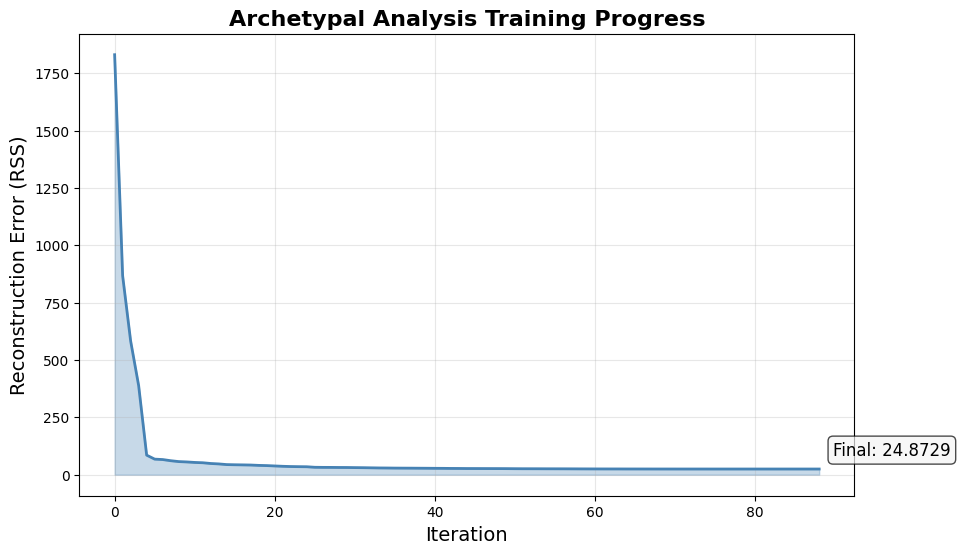

💡 The loss decreased from 1830.3200 to 24.8729
   That's a 98.6% improvement!


In [15]:
# Visualize the training progress
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the loss curve
ax.plot(model.loss_, linewidth=2, color="steelblue")
ax.fill_between(range(len(model.loss_)), model.loss_, alpha=0.3, color="steelblue")

# Styling
ax.set_title("Archetypal Analysis Training Progress", fontsize=16, fontweight="bold")
ax.set_xlabel("Iteration", fontsize=14)
ax.set_ylabel("Reconstruction Error (RSS)", fontsize=14)
ax.grid(True, alpha=0.3)

# Add final value annotation
final_loss = model.loss_[-1]
ax.annotate(
    f"Final: {final_loss:.4f}",
    xy=(len(model.loss_) - 1, final_loss),
    xytext=(10, 10),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="whitesmoke", alpha=0.7),
    fontsize=12,
)

plt.show()

print(f"💡 The loss decreased from {model.loss_[0]:.4f} to {model.loss_[-1]:.4f}")
print(
    f"   That's a {((model.loss_[0] - model.loss_[-1]) / model.loss_[0] * 100):.1f}% improvement!"
)

## Understanding the Results

Now comes the exciting part - interpreting what our model discovered! The trained AA model provides three key outputs:

### 🎯 Archetypes: The "Pure Types"

The archetypes represent the extreme "corner points" of your data. In the Iris dataset, these correspond to flowers with the most distinctive characteristic combinations.

We'll use PCA to project our 4D iris data into 2D for visualization. While this projection may distort some relationships, it gives us valuable intuition about where archetypes lie relative to the data.

:::{warning}
PCA projection can be misleading - an archetype might appear "inside" the data cloud in 2D but still be extreme in the original 4D space!
:::


What to expect:
- Archetypes typically appear **near the boundary** of the data cloud
- They represent the most **extreme combinations** of features
- Unlike cluster centers, they're **not** necessarily **where most data points are**

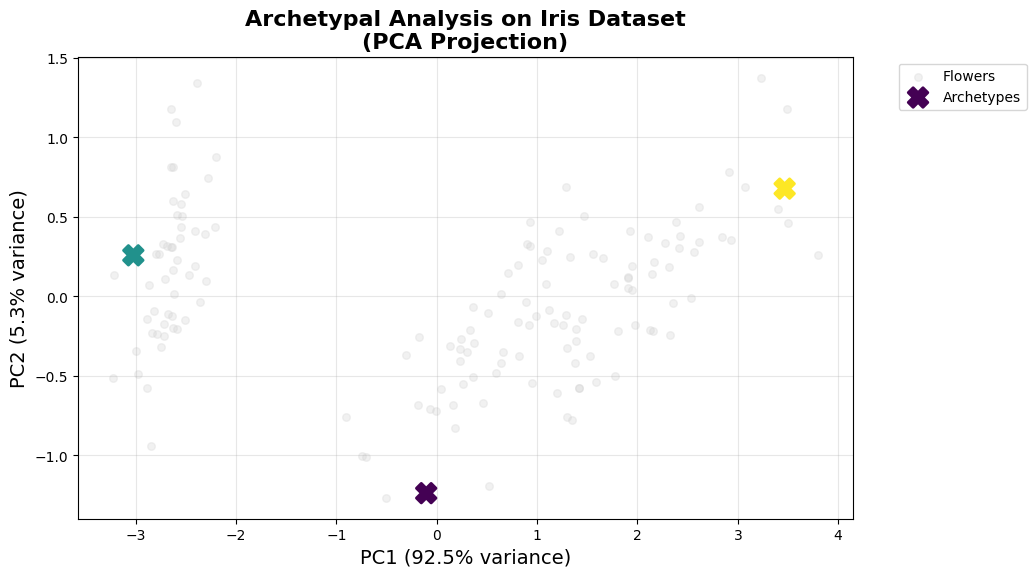

In [16]:
from sklearn.decomposition import PCA

# Project to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)
archetypes_2d = pca.transform(model.archetypes_)

# Create the visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data points
ax.scatter(X_2d[:, 0], X_2d[:, 1], color="lightgrey", alpha=0.3, s=30, label=f"Flowers")

# Plot archetypes prominently
ax.scatter(
    archetypes_2d[:, 0],
    archetypes_2d[:, 1],
    c=[0, 1, 2],
    marker="X",
    s=200,
    linewidth=2,
    label="Archetypes",
    zorder=5,
)

# Styling
ax.set_title(
    "Archetypal Analysis on Iris Dataset\n(PCA Projection)", fontsize=16, fontweight="bold"
)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)", fontsize=14)
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(True, alpha=0.3)

plt.show()

This visualization reveals archetypal analysis in action! Notice how:

- **Archetypes at boundaries**: The X markers (archetypes) are positioned near the edges of the data distribution
- **Convex hull corners**: The archetypes roughly define a triangle that encompasses most data points

:::{admonition} Key Insight
:class: tip
Every iris flower can be expressed as a weighted mixture of these three archetypal forms.
:::

#### 🔍 Deep Dive: Archetype Characteristics

Let's examine what makes each archetype unique by looking at their feature values. This helps us understand what "pure types" the algorithm discovered.

To do this, we'll plot the distribution of each feature across the dataset and mark where each archetype falls. This will highlight how archetypes represent extreme values in different dimensions.

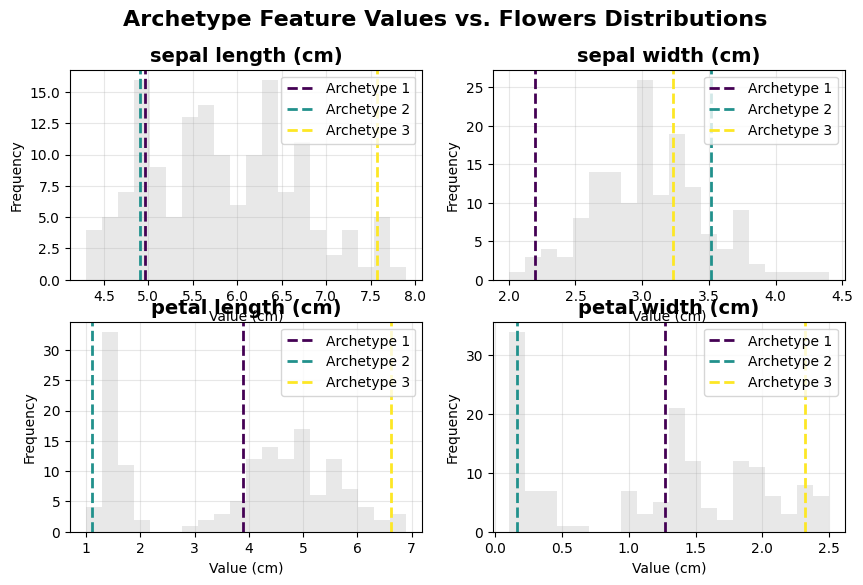

In [17]:
# Create feature comparison plot
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.ravel()

for i, feature_name in enumerate(feature_names):
    ax = axes[i]

    # Plot feature distributions for each species
    ax.hist(X[:, i], alpha=0.5, bins=20, color="lightgrey")

    # Mark archetype values
    for j, archetype in enumerate(model.archetypes_):
        ax.axvline(
            archetype[i],
            color=target_colors[j],
            linestyle="--",
            linewidth=2,
            label=f"Archetype {j+1}",
        )

    ax.set_title(f"{feature_name}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Value (cm)")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("Archetype Feature Values vs. Flowers Distributions", fontsize=16, fontweight="bold")

plt.show()

Analysis Tips:
   - Compare archetype values (dashed lines) with flowers distributions
   - Archetypes often represent extreme combinations of features
   - They may not correspond exactly to flowers means

### 📊 Flowers as mixtures of Archetypes: Similarity Degrees

The **similarity degrees** (also called alpha coefficients) are the heart of archetypal analysis. They tell us how to reconstruct each data point as a weighted mixture of archetypes.

Key properties:
- Each row represents one data point
- Each column represents one archetype  
- All values are non-negative
- Each row sums to exactly 1.0 (convex combination)

:::{admonition} Recipe Example
:class: tip
*"To make this iris flower, take 70% of Archetype 1, 20% of Archetype 2, and 10% of Archetype 3"*

In [8]:
# Extract similarity degrees (alpha coefficients)
similarity_degrees = model.similarity_degree_

print(f"📏 Similarity degrees shape: {similarity_degrees.shape}")
print(f"   {similarity_degrees.shape[0]} flowers × {similarity_degrees.shape[1]} archetypes")
print(f"\n✅ Verification - each row sums to 1.0:")
print(f"   Row sums: {similarity_degrees.sum(axis=1)[:5]} (showing first 5)")

print(f"\n🌸 First 5 flowers' archetype compositions:")
print("   [Archetype 1, Archetype 2, Archetype 3]")
for i in range(5):
    composition = similarity_degrees[i]
    # Convert to percentages for easier interpretation
    percentages = composition * 100
    print(
        f"   Flower {i+1:2d}: [{percentages[0]:5.1f}%, {percentages[1]:5.1f}%, {percentages[2]:5.1f}%]"
    )

📏 Similarity degrees shape: (150, 3)
   150 flowers × 3 archetypes

✅ Verification - each row sums to 1.0:
   Row sums: [1. 1. 1. 1. 1.] (showing first 5)

🌸 First 5 flowers' archetype compositions:
   [Archetype 1, Archetype 2, Archetype 3]
   Flower  1: [  0.0%,  94.7%,   5.3%]
   Flower  2: [ 14.4%,  85.6%,   0.0%]
   Flower  3: [  9.2%,  90.8%,   0.0%]
   Flower  4: [ 15.6%,  84.4%,   0.0%]
   Flower  5: [  0.0%,  95.4%,   4.6%]


Interpretation:
   - Flower 1 is mostly like Archetype 2
   - Values show how 'pure' each flower is relative to the archetypes
   - Higher values = stronger resemblance to that archetype

#### 🎨 Visualizing Similarity Degrees: The Simplex Plot

The **simplex plot** is the perfect way to visualize this relationships. It's like a map where:

- **Corners** = Pure archetypes (100% one type, 0% others)
- **Edges** = Mixtures of two archetypes  
- **Interior** = Mixtures of all three archetypes
- **Distance from corner** = How different you are from that pure type

This geometric representation makes it easy to spot patterns:
- Points clustered near corners are "pure" examples
- Points along edges are hybrids of two types
- Points in the center are balanced mixtures

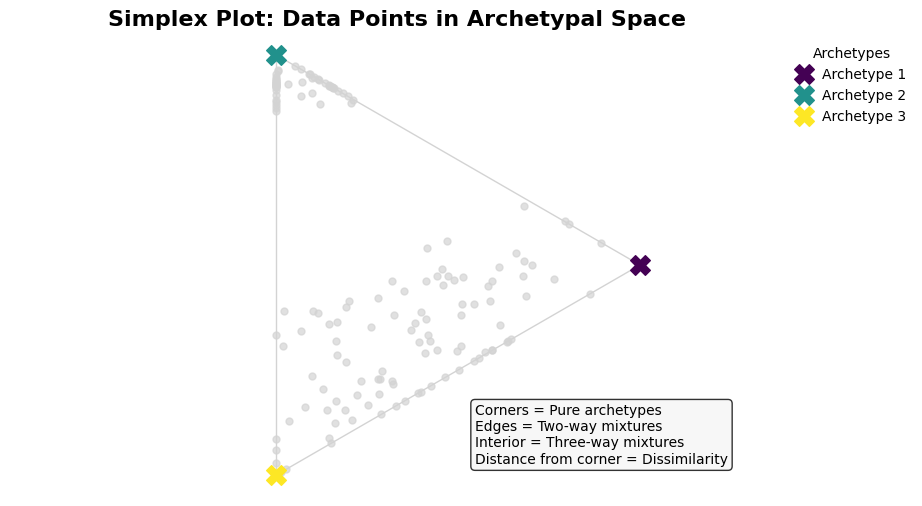

In [18]:
from archetypes.visualization import simplex

# Create simplex plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data points in archetypal space
simplex(
    similarity_degrees,
    s=25,  # Point size
    alpha=0.7,  # Transparency
    show_vertices=True,  # Show archetype corners
    vertices_size=200,  # Size of archetype markers
    vertice_marker="X",  # Archetype marker style
    vertices_color=[0, 1, 2],  # Match species colors
    vertices_labels=[f"Archetype {i+1}" for i in range(3)],
    ax=ax,
)

ax.set_title("Simplex Plot: Data Points in Archetypal Space", fontsize=16, fontweight="bold")
ax.set_aspect("equal")

# Add explanatory text
textstr = "\n".join(
    [
        "Corners = Pure archetypes",
        "Edges = Two-way mixtures",
        "Interior = Three-way mixtures",
        "Distance from corner = Dissimilarity",
    ]
)
props = dict(boxstyle="round", facecolor="whitesmoke", alpha=0.8)
ax.text(0.6, 0.2, textstr, transform=ax.transAxes, fontsize=10, verticalalignment="top", bbox=props)

plt.show()

Quick Analysis:
   - Points near corners are 'pure' examples of that archetype
   - Most flowers are mixtures rather than pure types

#### 🎨 Alternative View: Stacked Bar Chart

Another powerful way to visualize archetypal compositions is through stacked bar charts. This view is especially useful for:

- **Ranking** flowers by purity (how close to a single archetype)
- **Identifying transitions** between archetypal regions
- **Spotting outliers** or unusual mixtures

Let's sort the flowers to create a meaningful progression from one archetypal extreme to another.

In [19]:
# Sort flowers by archetypal similarity for better visualization
from archetypes.datasets import sort_by_archetype_similarity

print("🔄 Sorting flowers by archetypal similarity...")
ordered_similarity_degrees, sorting_info = sort_by_archetype_similarity(
    similarity_degrees, [similarity_degrees], archetypes=model.archetypes_
)

print(f"✅ Flowers reordered to show archetypal progression")

🔄 Sorting flowers by archetypal similarity...
✅ Flowers reordered to show archetypal progression


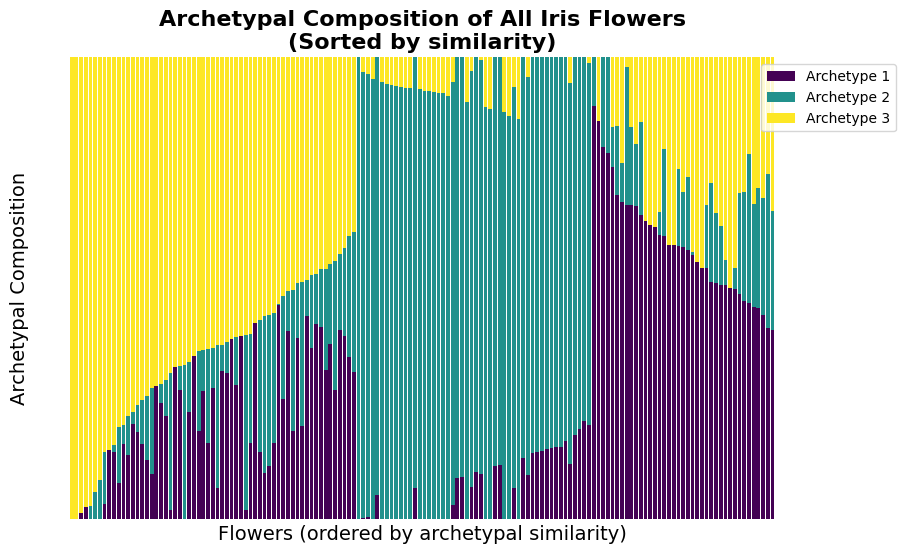

In [20]:
from archetypes.visualization import stacked_bar

# Create stacked bar visualization
fig, ax = plt.subplots(figsize=(10, 6))

stacked_bar(ordered_similarity_degrees, ax=ax)

# Enhance the plot
ax.set_xlabel("Flowers (ordered by archetypal similarity)", fontsize=14)
ax.set_ylabel("Archetypal Composition", fontsize=14)
ax.set_title(
    "Archetypal Composition of All Iris Flowers\n(Sorted by similarity)",
    fontsize=16,
    fontweight="bold",
)

# Add archetype labels
legend_labels = [f"Archetype {i+1}" for i in range(3)]
ax.legend(legend_labels, loc="upper right", bbox_to_anchor=(1.12, 1))

# Add grid for easier reading
ax.grid(True, alpha=0.3, axis="y")

plt.show()

What you're seeing:
   - Each bar represents one iris flower
   - Colors show the mixture of archetypes
   - Taller segments = stronger resemblance to that archetype

### 🧬 How Archetypes are Built: Archetypes similarity coefficients

The **archetypes similarity coefficients** (beta coefficients) reveal the "DNA" of each archetype - they show which original flowers were used to construct each archetypal extreme.

:::{admonition} Key insight
:class: tip

Archetypes are not abstract mathematical constructs - they're actual convex combinations of real flowers from your dataset!
:::

This makes archetypal analysis incredibly interpretable: you can always trace back to see exactly which observations define each pure type.

In [21]:
# Extract archetypes similarity coefficients (beta coefficients)
archetypes_similarity_degree = model.archetypes_similarity_degree_

print(f"🧬 Archetypes similarity degree shape: {archetypes_similarity_degree.shape}")
print(
    f"   {archetypes_similarity_degree.shape[0]} archetypes × {archetypes_similarity_degree.shape[1]} flowers"
)

print(f"\n🌸 Which flowers build each archetype:")
for k in range(model.n_archetypes):
    # Find non-zero contributors (flowers that help define this archetype)
    contributing_flowers = archetypes_similarity_degree[k].nonzero()[0]
    weights = archetypes_similarity_degree[k][contributing_flowers]

    print(f"\n   Archetype {k+1} is built from {len(contributing_flowers)} flowers:")
    for flower_idx, weight in zip(contributing_flowers, weights):
        species_idx = iris.target[flower_idx]
        species_name = target_names[species_idx]
        print(f"      Flower #{flower_idx:3d} ({species_name:10s}): {weight:.3f} contribution")

🧬 Archetypes similarity degree shape: (3, 150)
   3 archetypes × 150 flowers

🌸 Which flowers build each archetype:

   Archetype 1 is built from 2 flowers:
      Flower # 60 (versicolor): 0.608 contribution
      Flower #106 (virginica ): 0.392 contribution

   Archetype 2 is built from 3 flowers:
      Flower # 13 (setosa    ): 0.364 contribution
      Flower # 14 (setosa    ): 0.344 contribution
      Flower # 22 (setosa    ): 0.292 contribution

   Archetype 3 is built from 3 flowers:
      Flower #109 (virginica ): 0.268 contribution
      Flower #117 (virginica ): 0.304 contribution
      Flower #118 (virginica ): 0.429 contribution


What you're seeing:
   - Each archetype is a weighted average of just a few real flowers
   - These 'defining flowers' represent the most extreme examples
   - All other flowers are then expressed as mixtures of these archetypes

#### 🎯 Visualizing the Defining Flowers

Let's see where these "defining flowers" (the ones that build our archetypes) are located in our dataset. This helps us understand which specific specimens represent the pure archetypal forms.

What makes a flower "defining"?
- It has extreme characteristics that push the boundaries of the dataset
- It contributes significantly to defining an archetypal corner
- It represents a "pure" form that other flowers can be compared against

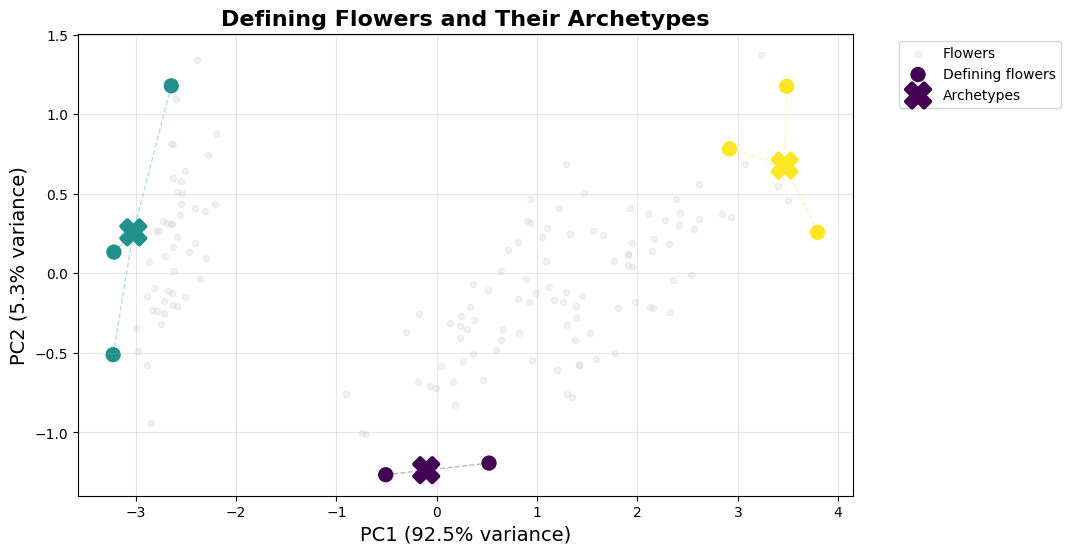

In [22]:
# Find all flowers that contribute to archetypes
archetype_indices, flower_indices = archetypes_similarity_degree.nonzero()
flowers_2d = pca.transform(X[flower_indices])

# Create enhanced visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all data points (background)
ax.scatter(X_2d[:, 0], X_2d[:, 1], color="lightgrey", alpha=0.3, s=20, label="Flowers")

# Highlight defining flowers
ax.scatter(
    flowers_2d[:, 0],
    flowers_2d[:, 1],
    c=archetype_indices,
    marker="o",
    s=100,
    label=f"Defining flowers",
)

# Plot archetypes
ax.scatter(
    archetypes_2d[:, 0],
    archetypes_2d[:, 1],
    color=target_colors,
    marker="X",
    s=300,
    linewidth=3,
    label="Archetypes",
    zorder=10,
)

# Draw lines from defining flowers to their archetypes
for i in range(model.n_archetypes):
    mask = archetype_indices == i
    defining_flowers_2d = flowers_2d[mask]
    for flower_pos in defining_flowers_2d:
        ax.plot(
            [flower_pos[0], archetypes_2d[i, 0]],
            [flower_pos[1], archetypes_2d[i, 1]],
            "--",
            alpha=0.3,
            linewidth=1,
            zorder=0,
            color=target_colors[i],
        )

# Styling
ax.set_title("Defining Flowers and Their Archetypes", fontsize=16, fontweight="bold")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)", fontsize=14)
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(True, alpha=0.3)

plt.show()

Observations:
   - Defining flowers (large circles) are often at data boundaries
   - Each archetype (X) is the weighted center of its defining flowers
   - Dashed lines show the contribution relationships
   - Most flowers are 'ordinary' - only extreme ones become defining flowers

## Key Takeaways

Congratulations! You've successfully completed your first archetypal analysis. Here's what you've learned:

### 🔑 Core Concepts

1. **Archetypes are interpretable**: They represent extreme, "pure" types built from real data points
2. **Every point is a mixture**: Each observation is expressed as a weighted combination of archetypes
3. **Boundary-focused**: Unlike clustering, AA finds the edges and extremes of your data space
4. **Convex combinations**: All relationships are expressed as non-negative weights that sum to 1

### 🛠️ Practical Skills
- How to set up and train an AA model
- Interpreting similarity coefficients (alpha coefficients) 
- Understanding archetypes similarity coefficients (beta coefficients)
- Creating informative visualizations
- Analyzing archetypal characteristics

### 🚀 Next Steps

Ready to dive deeper? Here are your next adventures:

#### 📚 Explore Advanced Variants
- `BiAA`: Bi-Archetypal Analysis, for finding archetypes in both rows and columns
- `ADA`: Archetypoids Analysis, for more interpretable archetypes
- `FairAA`: Fair Archetypal Analysis for bias-aware modeling
- `KernelAA`: Kernel Archetypal Analysis for non-linear relationships

#### 🧪 Try Different Datasets
- Load your own data and discover its archetypal structure
- Experiment with different numbers of archetypes
- Compare results across different initialization methods

#### ⚙️ Optimization Tuning
- Try different optimizers: `"nnls"`, `"pgd"` or others 
- Adjust convergence criteria for your specific needs
- Use custom initialization for domain-specific insights

**Happy archetypal analyzing!** 🎉